# ICV. Project

**Student Information**: Anna Boronina

**Group**: BS18-DS-01 

**Telegram**: @whoorma




[The link to the results](https://drive.google.com/drive/folders/1b6MuCJwhsIQXu-wUQzByxQlwEQp8JUsu?usp=sharing). The structure:
```
|_images
  |_comparison
  |_detection
|_videos
  |_comparison
  |_detection
```

In _images_ folder there are pairs: (_image_, _image_detected_), where the first one is the original image, and the second one is the original image with skeleton drawn.

The _videos_ folder contains two folders: _comparison_ and _detection_. (The same below applies to *images/* folder)
_Comparison_ folder contains triples (_image_, _video_, _video_compared_), where the first one is the image of a correctly performed exercise; the second one is _how_ the exercise was performed by someone else. The last one is the result of my algorithm. In the top left corner it shows the overall accuracy of performing the exercise, and to each skeleton point there is an accuracy score attached.


**If you want to see the results**, follow the link from above and open the files.

**If you want to upload images and videos and run the code**, follow the same link and download all images without postfix _detected_ in their names and all the videos without potfixes _detected_ and _compared_.

[The link to the Colab Notebook (Part 1 - before 29.09)](https://colab.research.google.com/drive/15Ohc_B71a1okiOJwj8_jiNJ6mQQoaz5b?usp=sharing).

[The link to the Colab Notebook (Part 2 - after 29.09)](https://colab.research.google.com/drive/1lqmjh_4BXE2Ap-tTGTO6NIU4grXxNZCE?usp=sharing).



## Installs and imports

In [ ]:
from IPython.display import clear_output, HTML

!mkdir images
!mkdir videos

# download the images
!wget https://i.imgur.com/OWfrJiN.jpg -O images/people1.jpg
!wget https://i.imgur.com/nSv2djx.png -O images/people2.png
!wget https://i.imgur.com/rfIBzFP.jpg -O images/meditate.jpg
!wget https://i.imgur.com/fVzKws2.jpg -O images/people4.jpg
!wget https://i.imgur.com/0o2RcED.jpg -O images/people5.jpg
!wget https://i.imgur.com/50zrhAl.png -O images/people6.png
!wget https://i.imgur.com/RbCIm4T.jpg -O images/meditate2.jpg
!wget https://i.imgur.com/b0zJlkH.jpg -O images/utanasana.jpg
!wget https://i.imgur.com/oyOtcvD.jpg -O images/planka.jpg
!wget https://i.imgur.com/Q095i14.jpg -O images/legsup.jpg
!wget https://i.imgur.com/pXYesgg.jpg -O images/planka2.jpg

# paths to the images
IMAGES = [
          'images/people1.jpg',
          'images/people2.png',
          'images/meditate.jpg', # yoga 1
          'images/people4.jpg',
          'images/people5.jpg',
          'images/people6.png',
          'images/meditate2.jpg', # yoga 1
          'images/utanasana.jpg',
          'images/planka.jpg',
          'images/planka2.jpg',
          'images/legsup.jpg'
          ]

# paths to the videos (they are to be upload manually)
VIDEOS = [
          'videos/people_walking1.mp4',
          'videos/people_walking2.mp4',
          'videos/people_walking3.mp4',
          'videos/people_walking4.mp4',
          'videos/people_exercising1.mp4',
          'videos/people_exercising2.mp4',
          'videos/people_exercising3.mp4',
          'videos/people_exercising4.mp4',
          ]

VIDEOS_DETECTION = [
            'videos/yoga/utanasana.mp4',
            'videos/yoga/meditate.mp4',
            'videos/legsup.mp4',
            'videos/planka.mp4'
]

clear_output()

In [ ]:
!pip install mediapy
!pip install imgaug==0.2.5
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python==4.5.1.48
clear_output()

In [ ]:
from enum import Flag, auto

import torch
from torchvision.transforms import transforms
from torchvision.models.detection import keypointrcnn_resnet50_fpn
import torch.nn as nn

import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from mediapy import VideoWriter, read_video

import numpy as np
from time import time

from collections import OrderedDict
from base64 import b64encode
from os import listdir

import numpy as np

In [ ]:
cv2.__version__ # should be 4.5.1

'4.5.1'

## Global variables & functions

In [ ]:
# KeypointRCNN returns 17 classes, one for each body point it detects
key2bodypart = {
    0: 'nose',
    1: 'left eye',
    2: 'right eye',
    3: 'left ear',
    4: 'right ear',
    5: 'left shoulder',
    6: 'right shoulder',
    7: 'left elbow',
    8: 'right elbow',
    9: 'left wrist',
    10: 'right wrist',
    11: 'left hip',
    12: 'right hip',
    13: 'left knee',
    14: 'right knee',
    15: 'left ankle',
    16: 'right ankle'
}

# body points to connect to get a human shape
connected_pairs = [
                   (0, 1), (0, 2), (1, 2), (2, 4), (1, 3),  # face
                   (5, 6), (5, 7), (7, 9), (6, 8), (8, 10), # arms
                   (5, 11), (6, 12), (11, 12),              # middle part of the body
                   (11, 13), (12, 14), (13, 15), (14, 16)   # legs
]

class Device(Flag):
    GPU = auto()
    CPU = auto() 

I do not apply any normalization for the images because doing it gave worse results.

In [ ]:
# transformation from image to tensor - no normalization
TRANSFORM = transforms.Compose([
                                transforms.ToTensor()
])

# define the model
model = keypointrcnn_resnet50_fpn(pretrained=True)
# define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
devicetype = Device.GPU if device.type == 'cuda' else Device.CPU
# set the model to the testing mode
model.to(device).eval()
clear_output()

In [ ]:
device.type, devicetype

('cuda', <Device.GPU: 1>)

In [ ]:
def show_in_row(list_of_images, figsize=(20, 20), titles=None, disable_ticks=True):
    '''
    shows multiple images in one row; credit: Karam
    @param list_of_images: list of image to show
    @param titles: list of titles for images; default is None
    @param disable_ticks: whether to show ticks for images or not; default is False

    @return None
    '''
    plt.figure(figsize=figsize)
    count = len(list_of_images)
    for idx in range(count):
        subplot = plt.subplot(1, count, idx+1)
        if titles is not None:
            subplot.set_title(titles[idx])
        
        img = list_of_images[idx]
        cmap = 'gray' if (len(img.shape) == 2 or img.shape[2] == 1) else None
        subplot.imshow(img, cmap=cmap)
        if disable_ticks:
            plt.xticks([]), plt.yticks([])
    plt.show()


def read_image(path):
    '''
    reads the image given a path
    @param path: path to the image
    @return image as numpy.ndarray
    '''
    orig_image = cv2.imread(path)
    orig_image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)
    return orig_image


def get_new_name(name, postfix='detected'):
    '''
    generates a new name for file
    @param name: original file name
    @param postfix: postfix to add to the generated filename; default is 'detected'
    @return the generated name 
    '''
    name, ext = name.split('.')
    return f'{name}_{postfix}.{ext}'

In [ ]:
def draw_body(all_keypoints, all_scores, connected_pairs, image, color_edges=(200, 0, 0), color_lines=(0, 200, 0), threshold=0.95):
    '''
    draws human shape on an image
    @param all_keypoints: keypoints returned by the model;
                        contains one entry per human
    @param all_scores: score for each detected human
    @param connected_pairs: body points to connect; list of pairs
    @param image: the image used for humans detection
    @param color_edges: color for drawing edges; default is red
    @param color_lines: color for drawing lines, which connect edges; default is green
    @param threshold: threshold for score; default is 0.95

    @return a copy of the original image with human shape(s) drawn on it
    '''
    imagecopy = image.copy()
    for keypoints, score in zip(all_keypoints, all_scores):
        if score < threshold:
            continue
        if len(keypoints.shape) == 3:
            keypoints = keypoints.reshape(-1, 3)
        if devicetype == Device.GPU:
            keypoints = keypoints.cpu().detach().numpy()

        for idx, keypoint in enumerate(keypoints):
            x, y = keypoint[0], keypoint[1]
            connect_to = filter(lambda p: p[0] == idx, connected_pairs)
            for con in connect_to:
                xx, yy = int(keypoints[con[1]][0].item()), int(keypoints[con[1]][1].item())
                cv2.line(imagecopy, (x, y), (xx, yy), color_lines, thickness=3)
            cv2.circle(imagecopy, (x, y), 3, color_edges, thickness=-1, lineType=cv2.FILLED)

    return imagecopy

In [ ]:
def detect_body(orig_image, model, transform=TRANSFORM, show=True, get_accuracies=False):
    '''
    detects human shape(s) in a given image
    @param orig_image: path to the image
    @param model: model to use for human shape detection
    @param transform: transformation for the image before passing to the model;
                      default is global TRANSFORM
    @param show: whether to show the image after detecting the shape or not;
                 default is True
    @return image as numpy.ndarray
    '''
    image = transform(orig_image)
    image = image.unsqueeze(0).to(device)

    start_time = time()
    with torch.no_grad():
        result = model(image)[0]
    end_time = time()

    new_image = draw_body(result['keypoints'], result['scores'], connected_pairs, orig_image)

    if show:
        plt.imshow(new_image)
    return result, new_image, end_time-start_time

## Detection

### Images

The detection performed by the model is not always perfect. Especially the last three. The model confused many body points and connected them incorrectly.



In [ ]:
def read_detect_save_images(paths, model, show=False):
    '''
    reads images, detects human shapes in them, saves new images
    @param paths: list of paths to the images
    @param model: model to use for human shape detection
    @param show: whether to show the images or not; default is False
    @return None
    '''
    for path in paths:
        image = read_image(path)
        _, new_image, _ = detect_body(image, model, show=False)
        new_name = get_new_name(path)
        _ = cv2.imwrite(new_name, cv2.cvtColor(new_image, cv2.COLOR_RGB2BGR))
        if show:
            print(f'path to image: {path}')
            show_in_row([image, new_image])

path to image: images/people1.jpg


<Figure size 1080x1080 with 0 Axes>

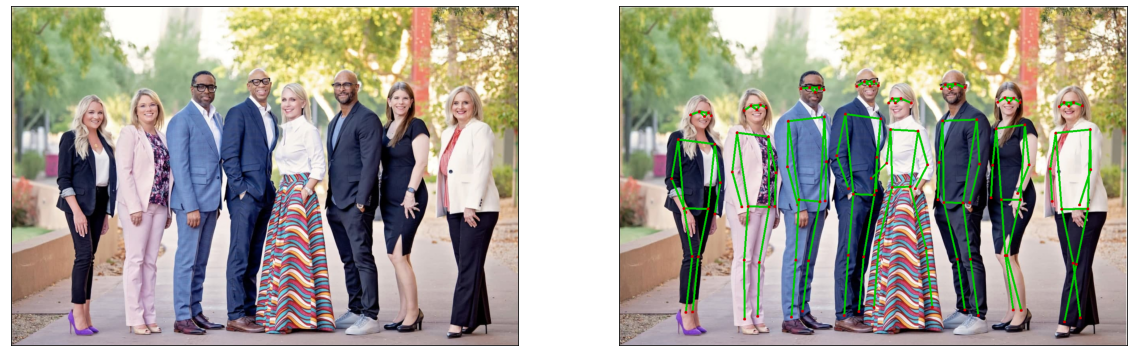

path to image: images/people2.png


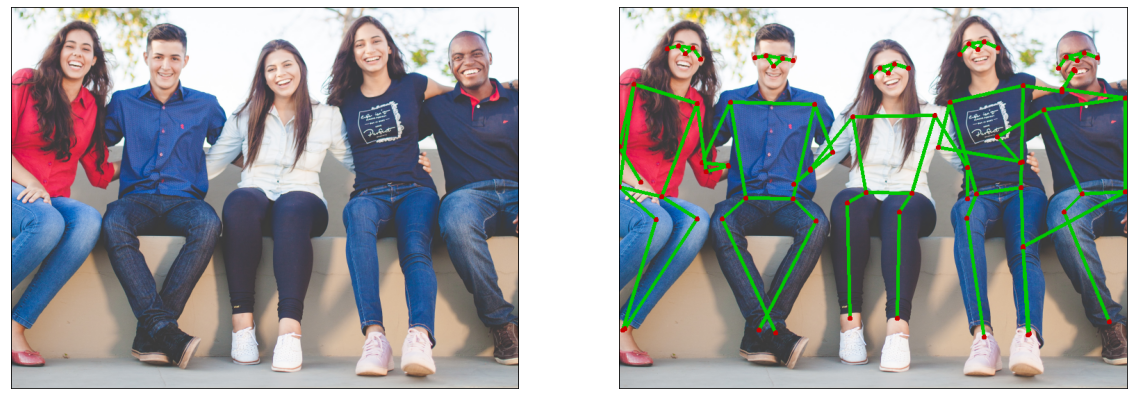

path to image: images/meditate.jpg


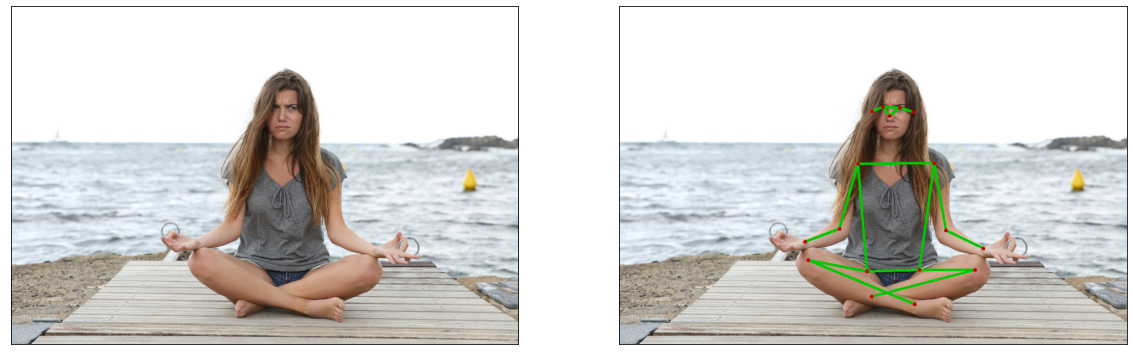

path to image: images/people4.jpg


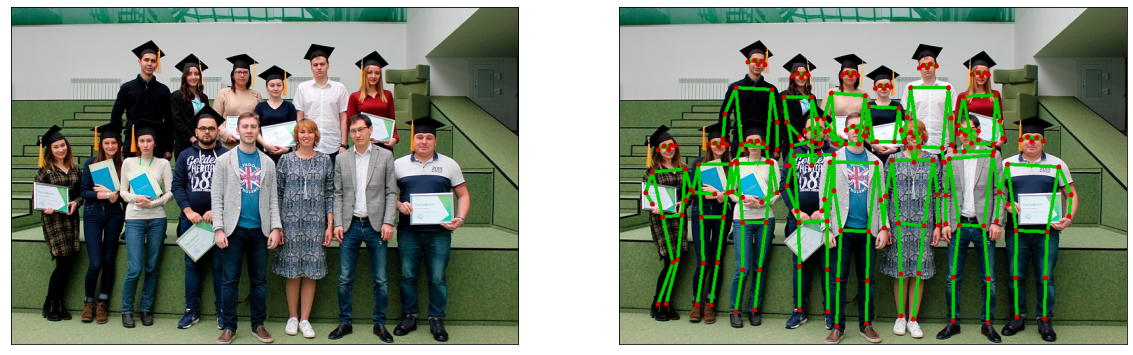

path to image: images/people5.jpg


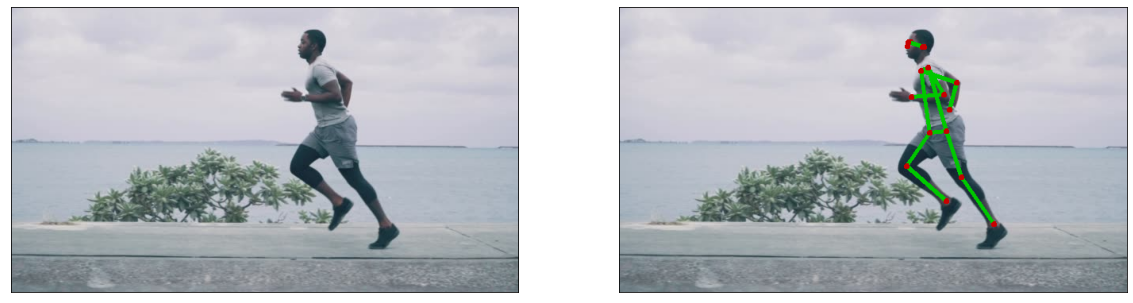

path to image: images/people6.png


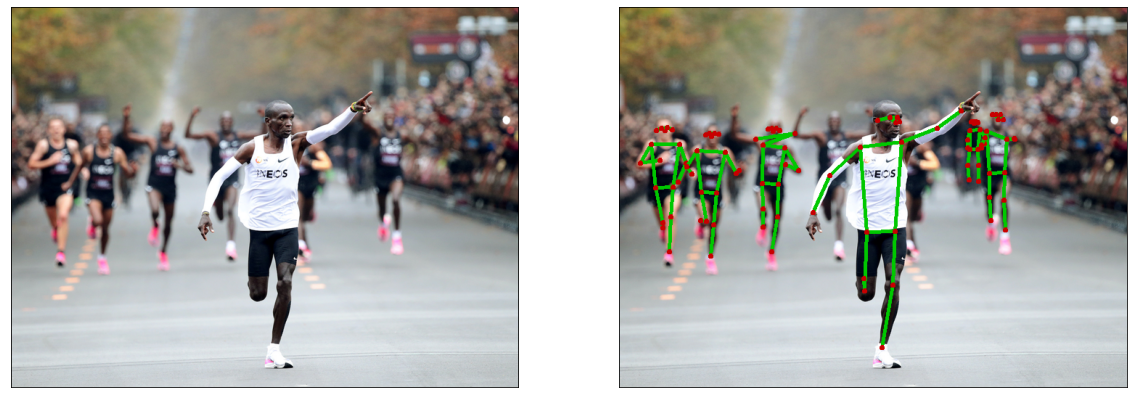

path to image: images/meditate2.jpg


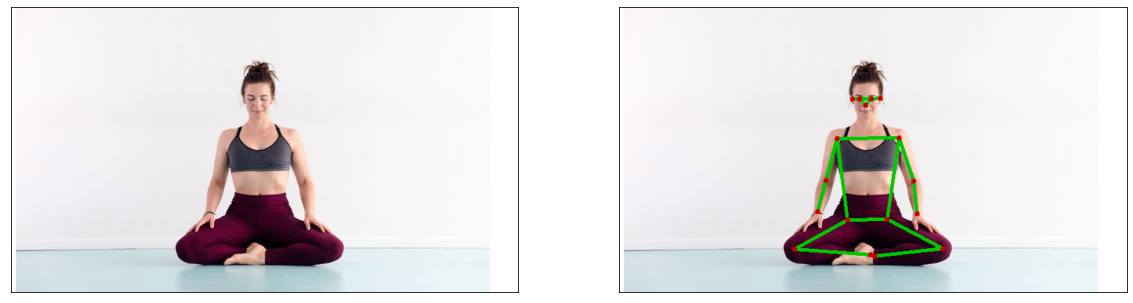

path to image: images/utanasana.jpg


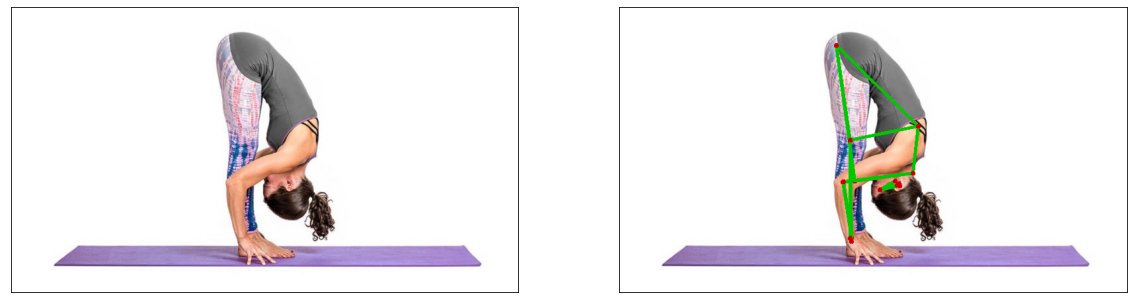

path to image: images/planka.jpg


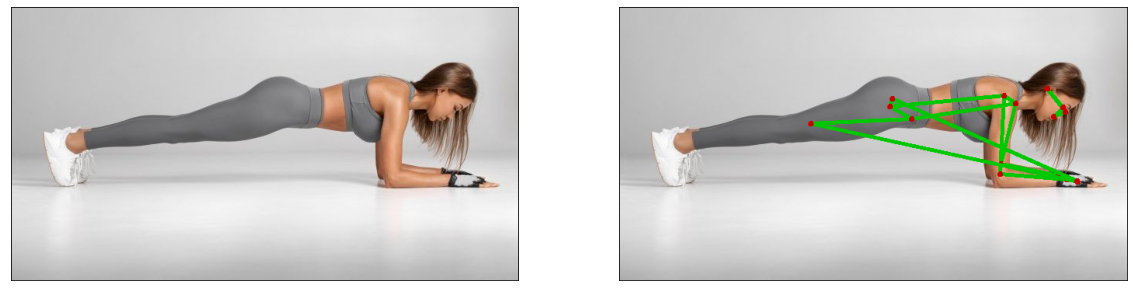

path to image: images/planka2.jpg


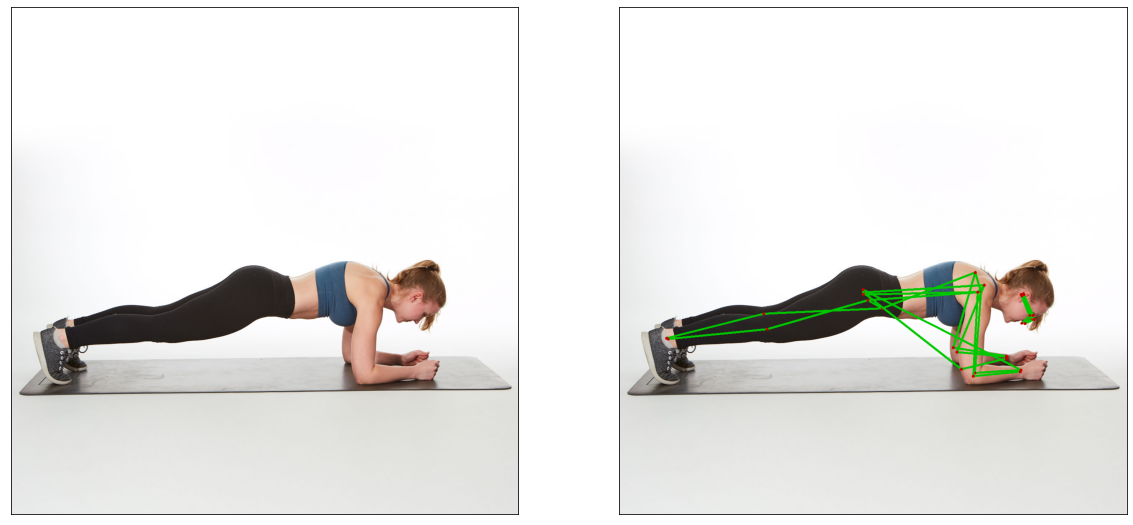

path to image: images/legsup.jpg


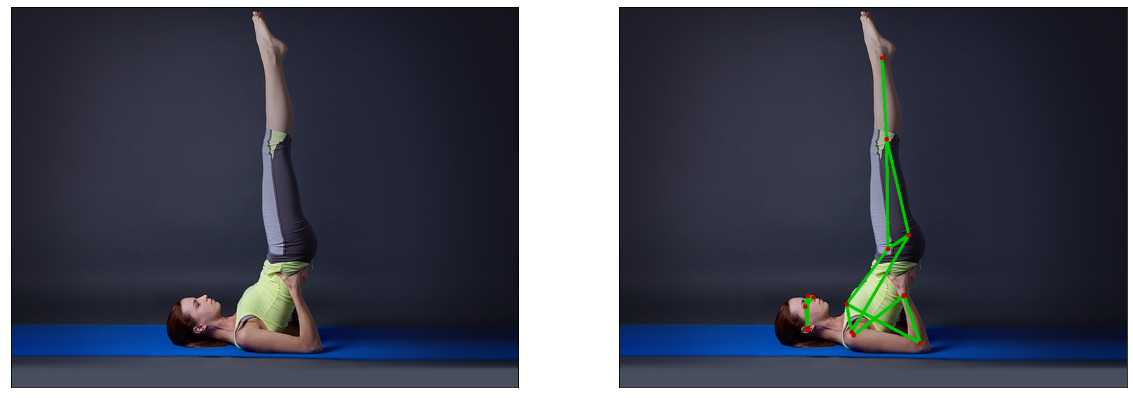

In [ ]:
plt.figure(figsize=(15, 15))
read_detect_save_images(IMAGES, model, show=True)

### Videos

In [ ]:
def read_video(path):
    '''
    read one video
    @param path: path to the video
    @return cap: video object, contains main video information
    @return fwidth: frame width
    @return fheight: frame height
    @return fps: frames per second of the video
    '''
    cap = cv2.VideoCapture(path)
    if not cap.isOpened():
        return
    fwidth, fheight = int(cap.get(3)), int(cap.get(4))
    fps = cap.get(cv2.CAP_PROP_FPS)
    return cap, fwidth, fheight, int(fps)


def play_video(cap):
    '''
    play one video if not in colab
    @param cap: video object, contains main video information
    @return None
    '''
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        cv2.imshow('', frame)
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break


def play_video_colab(path):
    '''
    play one video in colab
    @param path: path or url to the video
    @return html object with video
    '''
    video = open(path,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(video).decode()
    return HTML(f"""
    <video width=400 controls>
        <source src={data_url} type="video/mp4">
    </video>
    """)


def detect_bodies_in_video(cap, model):
    '''
    play one video
    @param cap: video object, contains main video information
    @param model: model to use for human shape detection
    @return frames with human detected in each of them
    '''
    new_frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            return new_frames
        img = np.uint8(Image.fromarray(frame).convert('RGB'))
        _, new_img, time_spent = detect_body(img, model, show=False)
        new_img = cv2.cvtColor(new_img, cv2.COLOR_RGB2BGR)
        fps = 1 / time_spent
        wait_time = max(1, int(fps / 4))
        new_frames.append(new_img)
        if cv2.waitKey(wait_time) & 0xFF == ord('q'):
            break
    return new_frames


def save_new_video(save_to, frames):
    '''
    save one video
    @param save_to: an instance of class mediapy.VideoWriter
    @frames: frames for the new video
    @return None
    '''
    for frame in frames:
        save_to.add_image(frame)

In [ ]:
def read_detect_save_videos(paths, model):
    '''
    reads videos, detects human shapes in them, saves new videos
    @param paths: list of paths to the videos
    @param model: model to use for human shape detection
    @return None
    '''
    for path in paths:
        try:
            videocap, fwidth, fheight, fps = read_video(path)
            new_name = get_new_name(path)
            new_frames = detect_bodies_in_video(videocap, model)
            if new_frames:
                with VideoWriter(new_name, fps=fps, shape=(fheight, fwidth)) as save_to:
                    save_new_video(save_to, new_frames)
                    print(f'new video saved to {new_name} :)')
            else:
                print(f'Video was corrupted, path: {path}')
        except:
            print(f'Check that the video exists, path: {path}')

In [ ]:
read_detect_save_videos(VIDEOS, model)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:114: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


new video saved to videos/people_walking1_detected.mp4 :)
new video saved to videos/people_walking2_detected.mp4 :)
new video saved to videos/people_walking3_detected.mp4 :)
new video saved to videos/people_walking4_detected.mp4 :)
new video saved to videos/people_exercising1_detected.mp4 :)
new video saved to videos/people_exercising2_detected.mp4 :)
new video saved to videos/people_exercising3_detected.mp4 :)
new video saved to videos/people_exercising4_detected.mp4 :)


Colab is not very good with playing the videos. So the best way to see them is to basically download them or follow the link given at the beginning of the document.

If you want to play just one video, do:
```python
play_video_colab(path_to_video)
```

## Comparison

**The idea**

This part presents a solution for human keypoints estimation for workout sessions. During the pandemic, most people got locked up in their houses without access to gyms, personal  rainers, or group workout sessions. In this case, the only choice is to work out from home using YouTube tutorials. 

The code below has two parts:
- Accuracy calculation between two images (one of them is the target, which means the correct way to perform an exercise)
- Accuracy calculation between a video and an image (in this case, image is the target).

I'll do it by comparing angles between same body parts from target and original sources. 

To be more precise...

Skeleton points are marked with red dots - you can see points from 5 to 16. Face points are not included as they are not important for this task.

Interesting angles are marked in blue. For example, angle 1 is an angle between lower and upper part of an arm. We look for the same angle in the second skeleton and compare two angles. Then, the closer the angle is to the target angle, the higher the accuracy score!

<img src="https://i.imgur.com/0VUnDza.jpg" width="300px">


In [ ]:
# CREDIT: https://stackoverflow.com/a/13849249/11355040
def unit_vector(v):
    '''
    Normalized a vector
    @param v: vector
    @return the unit vector of v
    '''
    return v / np.linalg.norm(v)

def angle_between(v1, v2):
    '''
    Returns the angle in radians between two vectors
    example of vector: (4, 5) - based in (0, 0)
    @param v1: the first vector
    @param v2: the second vector

    @return the angle between two vectors in radians
    '''
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

def vecs_to_zero_base(v1, v2):
    '''
    changes the basis; the new basis' (0, 0) will be at the point that is in both `v1` and `v2`
    example of vector: ((1, 1), (5, 6)) - tuple of two tuples, each with two numbers
    @param v1: the first vector 
    @param v2: the second vector

    @return the new two vectors in the new basis
    example of returned vector: (4, 5) - just one tuple, because now it starts from (0, 0)
    '''
    # find zero point - repeated coordinates
    assert v1[0] != v1[1] and v2[0] != v2[1], f'Expected a line, got a point: {v1}, {v2}'
    zero = (0, 0)
    if v1[0] == v2[0] or v1[0] == v2[1]:
        zero = v1[0]
    elif v1[1] == v2[0] or v1[1] == v2[1]:
        zero = v1[1]
    # move both vectors to new basis
    for i, coords in enumerate(v1):
        if coords == zero:
            v1 = v1[1 - i]
    for i, coords in enumerate(v2):
        if coords == zero:
            v2 = v2[1 - i]
    v1 = (v1[0] - zero[0], v1[1] - zero[1])
    v2 = (v2[0] - zero[0], v2[1] - zero[1])
    return v1, v2

def compare_two_bends(bend1, bend2, thresh=0.95):
    '''
    compares two bends and finds the accuracy between their angles
    example of bend: ((6, 2), (3, 5)), ((3, 5), (3, 7)) - two vectors, each vector - two points
    each vector will be translated to new basis
    @param v1: the first vector 
    @param v2: the second vector 
    
    @return accuracy score between 0 and 1
    '''
    bend1 = vecs_to_zero_base(bend1[0], bend1[1])
    bend2 = vecs_to_zero_base(bend2[0], bend2[1])
    angle1 = angle_between(bend1[0], bend1[1])
    angle2 = angle_between(bend2[0], bend2[1])
    div = angle1/angle2 if angle1 < angle2 else angle2/angle1
    accuracy = 1 if div > thresh else round(div, 2)
    return accuracy

An example of how accuracy calculation works. The code is below.

There are two vectors $v_1$ and $v_2$ sharing one point $(3, 5)$. Other two vectors $v_3$ and $v_4$ share $(3, 5)$ as well (it's just a coincidence). Let's define a bend: **a bend is two vectors sharing one point** ($v_1$ and $v_2$ is a bend and $v_3$ and $v_4$ is a bend). They are in the same basis. Now, we want to compare the angle between $v_1$ and $v_2$ with angle between $v_3$ and $v_4$. To do that, we move both bends' bases zeros to the point they share. The old coordinates are blue, and new bases is drawn in red.

After each of the got a new basis, we can calculate an angle between $v_1$ and $v_2$, also between $v_3$ and $v_4$. Then we can compare these angles and get accuracy score.

<img src="https://i.imgur.com/Q4EeRra.jpg" width="850">

In [ ]:
# code for the example above
v1, v2 = vecs_to_zero_base(((5, 2), (3, 5)), ((3, 5), (4, 8)))
v3, v4 = vecs_to_zero_base(((6, 2), (3, 5)), ((3, 5), (3, 7)))

print(f'v1: {v1}\tv2: {v2}\nv3: {v3}\tv4: {v4}')
print(f'accuracy score: {compare_two_bends((v1, v2), (v3, v4))}')

v1: (2, -3)	v2: (1, 3)
v3: (3, -3)	v4: (0, 2)
accuracy score: 0.95


In [ ]:
# repeated list of connected pairs. each pair is a pair of two classes
# (a class can be: eye, shoulder, knee, etc.)
# one number - one class - two coordinates
connected_pairs = [
                   (0, 1), (0, 2), (1, 2), (2, 4), (1, 3),  # face - doesn't matter for this part
                   (5, 6), (5, 7), (7, 9), (6, 8), (8, 10), # arms
                   (5, 11), (6, 12), (11, 12),              # middle part of the body
                   (11, 13), (12, 14), (13, 15), (14, 16)   # legs
]

# bends (definition is given above)
BENDS = {
          1: ((5, 7), (7, 9)),     2: ((5, 7), (5, 11)),     3: ((6, 12), (6, 8)),    4: ((6, 8), (8, 10)),
          5: ((5, 11), (11, 12)),  6: ((6, 12), (11, 12)),   7: ((11, 12), (11, 13)), 8: ((11, 12), (12, 14)),
          9: ((11, 13), (13, 15)), 10: ((12, 14), (14, 16)), 11: ((5, 11), (5, 6)),   12: ((6, 12), (5, 6))
}
BENDS = list(BENDS.values())

# check that every two-items tuple from `BENDS` is in `connected_pairs`
all([a[0] in connected_pairs and a[1] in connected_pairs for a in BENDS])

True

In [ ]:
def get_only_keypoints(image, model, transform=TRANSFORM, threshold=0.95):
    '''
    finds only keypoints for given image
    @param image: image to find keypoints for
    @param model: model to use for keypoints detection
    @param transform: transform to apply to image before feeding to model
    @param threshold: threshold for score; default is 0.95

    @return keypoints
    @return time spent on detecting the keypoint by the model
    '''
    # finds one human on the image
    image = transform(image)
    image = image.unsqueeze(0).to(device)

    start_time = time()
    with torch.no_grad():
        result = model(image)[0]
    end_time = time()

    # detect only one human
    keypoints = result['keypoints'][0]
    score = result['scores'][0]
    if score < threshold or len(keypoints) == 0:
        print('No humans detected, sorry')
        return
    if len(keypoints.shape) == 3:
        keypoints = keypoints.reshape(-1, 3)
    if devicetype == Device.GPU:
        keypoints = keypoints.cpu().detach().numpy()
    return keypoints, end_time - start_time


def get_joint_lines_descriptors(keypoints, bends=BENDS):
    '''
    maps keypoints to angles between each bend from `BENDS` and coordinates of each bend's "center"
    @param keypoints: keypoints from an image
    @param bends: bends; default is BENDS

    @return bends_edges: bends edges
    @return coords: coordinates; for further visualization
    '''
    # get points with coords: {0: (x, y), 1: (x, y), ...}
    points_coords = {idx: (int(keypoint[0].item()), int(keypoint[1].item())) for idx, keypoint in enumerate(keypoints)}
    bends_edges = []
    coords = []
    # substitute each key with a coordinate
    for line1, line2 in bends:
        line1_ = (points_coords[line1[0]], points_coords[line1[1]])
        line2_ = (points_coords[line2[0]], points_coords[line2[1]])
        bends_edges.append((line1_, line2_))
        index = line1[0] if line1[0] == line2[0] or line1[0] == line2[1] else line1[1]
        index_coord = points_coords[index]
        coords.append(index_coord)
    return bends_edges, coords


def build_dict(keys, values):
    '''
    builds a dictionary for case of repeated keys
    '''
    dic = {key: [] for key in keys}
    for key, value in zip(keys, values):
        dic[key].append(value)
    return dic


def compare_image_to_target_points(orig_image, target_keypoints, model, connected_pairs=connected_pairs, bends=BENDS, transform=TRANSFORM, threshold=0.95):
    '''
    compares image to target keypoints; returns accuracy score and new image which has accuracy scores drawn on it
    @param orig_image: original image
    @param target_keypoints: target keypoints (17 classes) + coordinates for each class
    @param model: model for detecting keypoints on the orig_image
    globals: 
    @param connected_pairs=connected_pairs
    @param bends=BENDS
    @param transform=TRANSFORM
    @param threshold=0.95

    @return full_acc: average accuracy for the image
    @new image which has accuracy scores drawn on it
    '''
    # create image copy to draw on
    copyimage = orig_image.copy()
    
    # get keypoints for original image
    keypoints, _ = get_only_keypoints(orig_image, model, transform)

    # get descriptors (really hard to explain this part)
    bends_edges_img, coords = get_joint_lines_descriptors(keypoints, bends)
    bends_edges_target, _ = get_joint_lines_descriptors(target_keypoints, bends)

    # calculate accuracies for each keypoint of the original image
    accuracies = []
    for joint_img, joint_target in zip(bends_edges_img, bends_edges_target):
        acc = compare_two_bends(joint_img, joint_target)
        accuracies.append(acc)

    # define scale for text
    textscale = copyimage.shape[0] / 350
    coords2accs = build_dict(coords, accuracies)
    # draw accuracies on the image
    for coord, accs in coords2accs.items():
        # some points can have two accuracies because they have two bends near them
        all_accs = ','.join(str(round(acc, 1)) for acc in accs)
        cv2.circle(copyimage, coord, 4, (227, 50, 0), thickness=-1)
        cv2.putText(copyimage, all_accs, coord, cv2.FONT_HERSHEY_PLAIN, textscale, (227, 50, 0), 2)

    full_acc = round(sum(accuracies) / len(accuracies), 2)
    cv2.putText(copyimage, str(full_acc), (10, int(copyimage.shape[0]*0.15)),
                cv2.FONT_HERSHEY_PLAIN, textscale + 0.4, (227, 50, 0), 2)
    return full_acc, copyimage

### Images

path to image: images/meditate.jpg


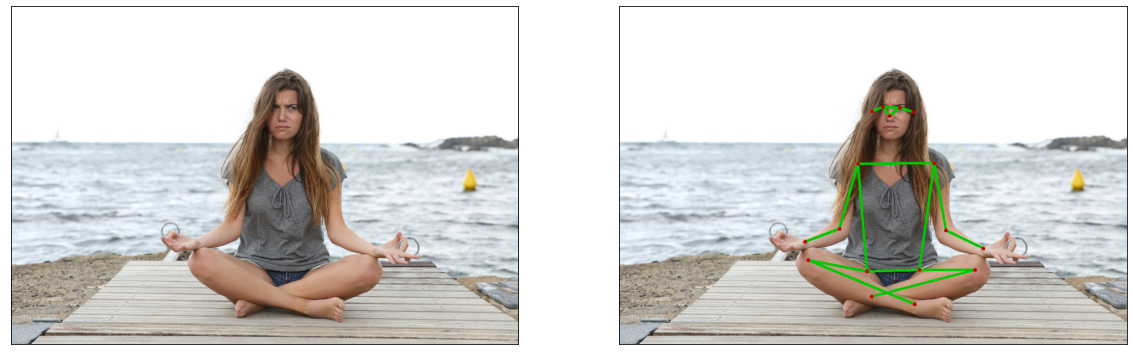

path to image: images/meditate2.jpg


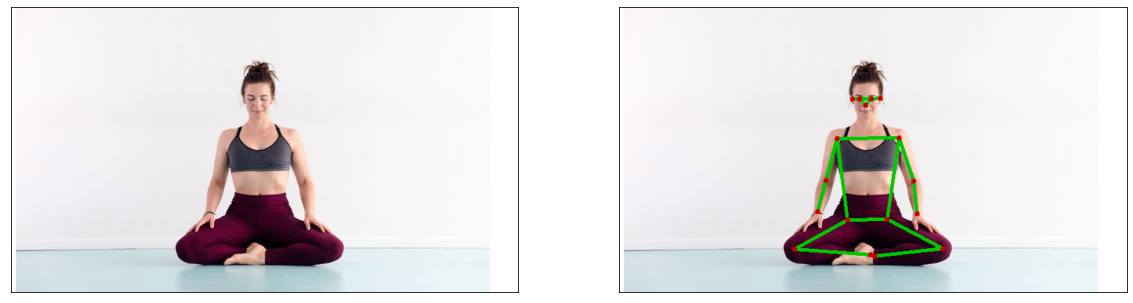

In [ ]:
read_detect_save_images(['images/meditate.jpg', 'images/meditate2.jpg'], model, show=True)

In [ ]:
def run_comparison(path1, path2, show=True, path_to_save_target=None, path_to_save_person=None):
    '''
    compares two images
    @param path1: path to the target image (the correct way to do something)
    @param path2: path to the original image
    @param show: whether to show the results or not; default is True
    @param path_to_save_target: path to save the target image (if neccesary, but the target image won't be changed)
    @param path_to_save_person: path to save the original image

    @return accuracy: accuracy of perfroming the action from target image
    '''
    # read both images
    target = read_image(path1)
    attempt = read_image(path2)
    # get target points
    target_keypoints, _ = get_only_keypoints(target, model)
    if show:
        show_in_row([target, attempt])
    # get accuracy and new image with all accuracies drawn on it
    accuracy, new_image = compare_image_to_target_points(attempt, target_keypoints, model)
    if show == True:
        show_in_row([target, new_image])
    # save images if specified so
    if path_to_save_target:
        _ = cv2.imwrite(path_to_save_target, cv2.cvtColor(target, cv2.COLOR_RGB2BGR))
    if path_to_save_person:
        _ = cv2.imwrite(path_to_save_person, cv2.cvtColor(new_image, cv2.COLOR_RGB2BGR))
    return accuracy

#### Example
You can find more in google disk, the link is at the beginning of the notebook.

<Figure size 1440x1440 with 0 Axes>

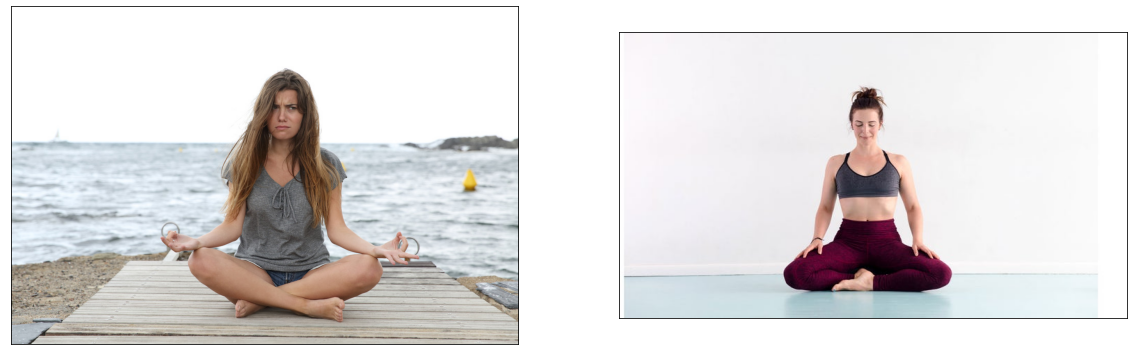

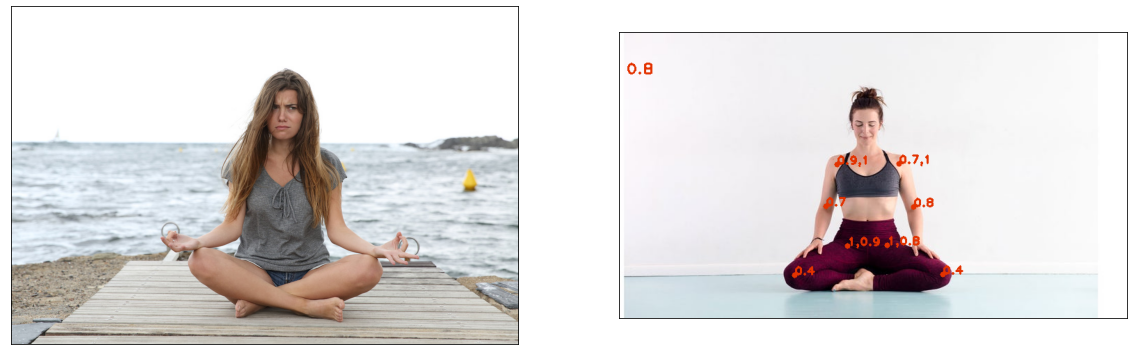

accuracy between images/meditate.jpg and images/meditate2.jpg is 0.8


In [ ]:
image1, image2 = 'images/meditate.jpg', 'images/meditate2.jpg'
new_name_image2 = get_new_name(image2, postfix='compared')
plt.figure(figsize=(20, 20))
accuracy = run_comparison(image1, image2, path_to_save_person=new_name_image2)
print(f'accuracy between {image1} and {image2} is {accuracy}')

<Figure size 1440x1440 with 0 Axes>

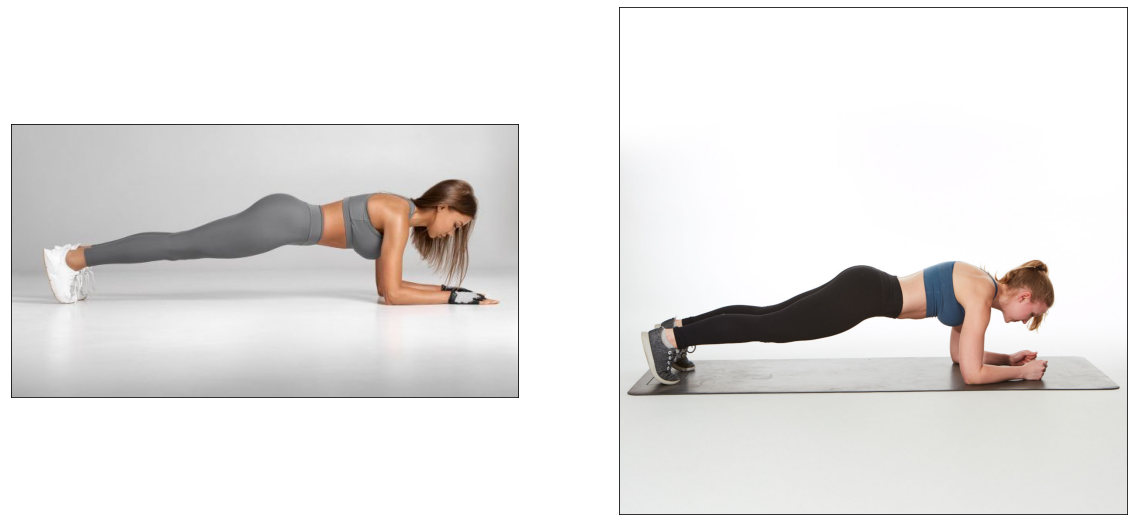

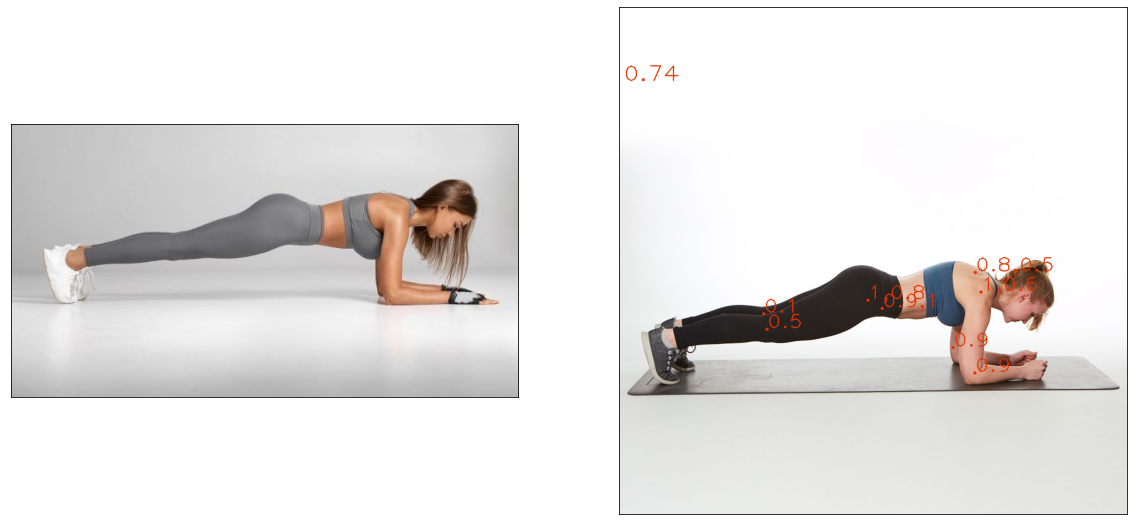

accuracy between images/planka.jpg and images/planka2.jpg is 0.74


In [ ]:
image1, image2 = 'images/planka.jpg', 'images/planka2.jpg'
new_name_image2 = get_new_name(image2, postfix='compared')
plt.figure(figsize=(20, 20))
accuracy = run_comparison(image1, image2, path_to_save_person=new_name_image2)
print(f'accuracy between {image1} and {image2} is {accuracy}')

### Videos

In [ ]:
def compare_video_with_image(videocap, image, model, transform=TRANSFORM):
    '''
    compare each frame of a video with image
    @param videocap
    @param image: target image
    @param model: model for keypoints detection
    @param transform: transformation for an image before feeding to the model

    @return new_frames: 
    '''
    # get target keypoints
    target_keypoints, time_spent = get_only_keypoints(image, model, transform)
    # iterate over video frames creating new video
    new_frames = []
    while videocap.isOpened():
        ret, frame = videocap.read()
        if not ret:
            return new_frames
        img = np.uint8(Image.fromarray(frame).convert('RGB'))
        # compare frame and target keypoints
        try:
            _, new_img = compare_image_to_target_points(img, target_keypoints, model)
        except:
            continue
        # get new frame
        new_img = cv2.cvtColor(new_img, cv2.COLOR_RGB2BGR)
        fps = 1 / time_spent
        wait_time = max(1, int(fps / 4))
        # append new frame
        new_frames.append(new_img)
        if cv2.waitKey(wait_time) & 0xFF == ord('q'):
            break
    return new_frames

In [ ]:
def run_video_comparison(videopath, imagepath, model, transform=TRANSFORM):
    '''
    runs comparison of video to an image
    @param videopath: path to video
    @param imagepath: path to image
    @param model: the model to detect a skeleton
    @param transform: transformation for an image

    @return None
    '''
    try:
        image = read_image(imagepath)
        videocap, fwidth, fheight, fps = read_video(videopath)
        new_name_video = get_new_name(videopath, postfix='compared')
        new_frames = compare_video_with_image(videocap, image, model)
        clear_output()
        if new_frames:
            with VideoWriter(new_name_video, fps=fps, shape=(fheight, fwidth)) as save_to:
                save_new_video(save_to, new_frames)
                print(f'new video saved to {new_name_video} :)')
        else:
            print(f'video was corrupted, path: {videopath}')
    except:
        print(f'check that the video exists, path: {videopath}')
        print(f'check that the image exists, path: {imagepath}')

#### Examples

You can find more in google disk, the link is at the beginning of the notebook.

In [ ]:
videopath = 'videos/utanasana.mp4'
imagepath = 'images/utanasana.jpg'
run_video_comparison(videopath, imagepath, model)

new video saved to videos/utanasana_compared.mp4 :)


In [ ]:
videopath = 'videos/meditate.mp4'
imagepath = 'images/meditate.jpg'
run_video_comparison(videopath, imagepath, model)

new video saved to videos/meditate_compared.mp4 :)


In [ ]:
videopath = 'videos/planka.mp4'
imagepath = 'images/planka.jpg'
run_video_comparison(videopath, imagepath, model)

new video saved to videos/planka_compared.mp4 :)


In [ ]:
videopath = 'videos/legsup.mp4'
imagepath = 'images/legsup.jpg'
run_video_comparison(videopath, imagepath, model)

new video saved to videos/legsup_compared.mp4 :)
